## Kindly note the codes below is only a framework. Due to the time constraints model optimisation was pushed into the next steps

## Listed below are the next steps that can be done 
### 1. Topic modelling on board_rating_reason columns
### 2. Resampling methods, listed below, can be used to reduce overfitting
####        a. LOOCV
####        b. k-fold
####        c. bootstraping

### 3. More models can be added to stacked algorithms such as 
####        a. SVM
####        b. CNN
####        c. LightGBM
####        d. CatBoost
####        e. Kernel Ridge regression

### 4. In Data Engineering section ANOVA test can be carried to make the feature selection more statistically profound


#### All case packages imported in the beginning, they are segregated depending on the tast that would be used to accomplish using them

In [1]:
# Project packages
import pandas as pd
import numpy as np
import math

In [2]:
# Visualisations
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
# Statistics
from scipy import stats
from scipy.stats import norm, skew
from statistics import mode

In [4]:
# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso, Ridge, RidgeCV, ElasticNet
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

In [5]:
# Handling the Warnings
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

####  Reading the given file and storing required columns in a data frame

In [6]:
df_train = pd.read_excel('Training sheet.xlsx')  # Reading the training data excel file in Panda data-frame.
df_test = pd.read_excel('Scoring Sheet.xlsx')  # Reading the test data excel file in Panda data-frame.

In [7]:
# Check the shape of the data to ensure all the columns have been incorporated from given excel file
print("\nThe train data size is: {} ".format(df_train.shape)) 


The train data size is: (1196, 15) 


In [8]:
#Creating a copy of the dataframe for manupulation
data_copy = df_train.copy()


#Dropping columns not needed for the analysis
data_copy.drop(['name', 'display_name','Category'], axis=1, inplace=True)

In [9]:
#Dropping columns not needed for the analysis
data_copy.drop(['board_rating_reason'], axis=1, inplace=True)

##### Even though board_rating_reason has been dropped but this column can be used separately to carry out NLP analysis
##### Eg. Topic Modelling can be used here to discover the abstract “topics” that occur in a collection of documents
##### Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic

In [10]:
# Check the shape of the data to ensure all the columns have been incorporated after necessary calculations
print("\nThe train data size is: {} ".format(data_copy.shape)) 


The train data size is: (1196, 11) 


In [11]:
# Changing the type of production year to string
data_copy.production_year = data_copy.production_year.apply(str)

#### EDA

In [12]:
# Inspecting the dataset
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196 entries, 0 to 1195
Data columns (total 11 columns):
id                                    1196 non-null int64
production_year                       1196 non-null object
movie_sequel                          1196 non-null int64
creative_type                         1196 non-null object
source                                1196 non-null object
production_method                     1196 non-null object
genre                                 1196 non-null object
language                              1196 non-null object
movie_board_rating_display_name       1196 non-null object
movie_release_pattern_display_name    1196 non-null object
total                                 1196 non-null int64
dtypes: int64(3), object(8)
memory usage: 102.9+ KB


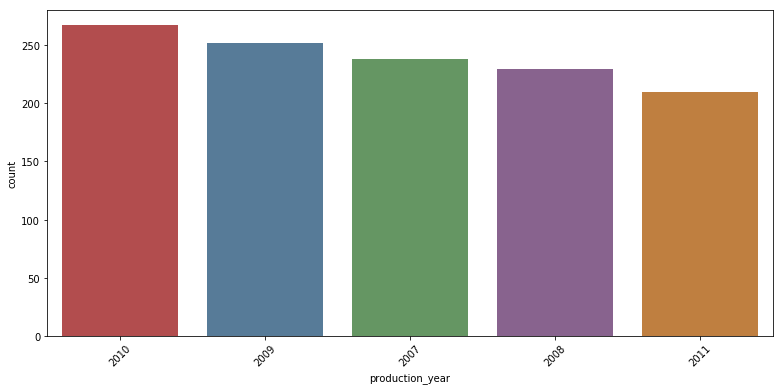

In [13]:
# Plotting a grapg betwwen the count of movies at production year level
plt.figure(figsize=(13,6))
descending_order = data_copy['production_year'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(x="production_year", data=data_copy, palette="Set1",saturation = 0.5, order=descending_order)
plt.xticks(rotation=45)
plt.show()

###### Insight : Maximum movies, in fiven dataset, were prodouced in the year 2010 followed by 2009

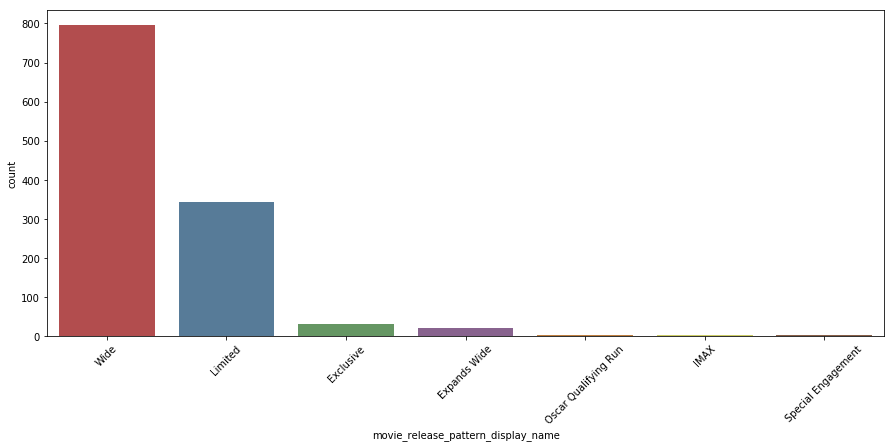

In [14]:
# Plotting a grapg betwwen the count of movies at release pattern level
plt.figure(figsize=(15,6))
descending_order = data_copy['movie_release_pattern_display_name'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(x="movie_release_pattern_display_name", data=data_copy, palette="Set1",saturation = 0.5, order=descending_order)
plt.xticks(rotation=45)
plt.show()

###### Majority of the movies were released as WIde followed by Limited

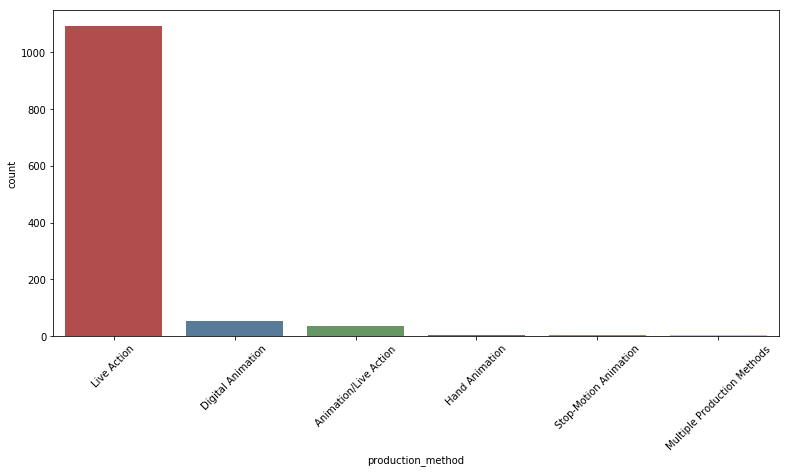

In [15]:
# Plotting a grapg betwwen the count of movies at production method level
plt.figure(figsize=(13,6))
descending_order = data_copy['production_method'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(x="production_method", data=data_copy, palette="Set1",saturation = 0.5, order=descending_order)
plt.xticks(rotation=45)
plt.show()

###### Majority of the movies were of type Live Action

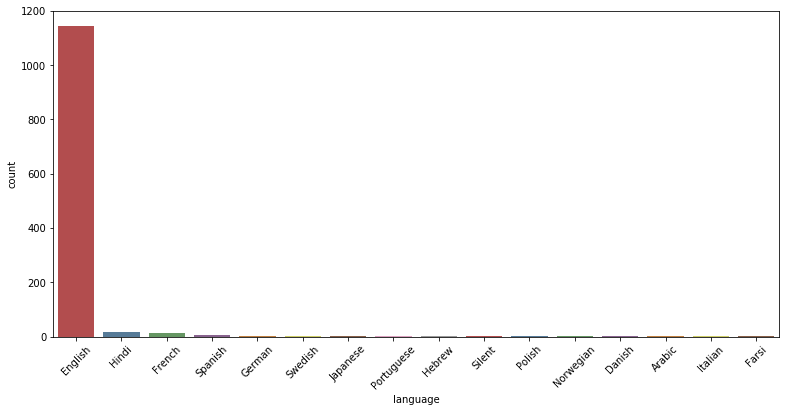

In [16]:
# Plotting a grapg betwwen the count of movies at language level
plt.figure(figsize=(13,6))
descending_order = data_copy['language'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(x="language", data=data_copy, palette="Set1",saturation = 0.5, order=descending_order)
plt.xticks(rotation=45)
plt.show()

### In the following section, based on the results of EDA binning of categorical data was done 
### Namely - Language, production_method, movie release pattern

In [17]:
# User defined function to bin language
def label_language (row):
    if row['language'] == 'English' :
        return 'English'
    return 'Other'

In [18]:
# User defined function to bin production_method
def label_prod_method (row):
    if row['production_method'] == 'Live Action' :
        return 'Live Action'
    if (row['production_method'] == 'Animation/Live Action' or row['production_method'] == 'Digital Animation') :
        return 'Animation'
    return 'Other'

In [19]:
# User defined function to bin movie_release_pattern_display_name
def label_release_pattern_display (row):
    if row['movie_release_pattern_display_name'] == 'Wide' :
        return 'Wide'
    if row['movie_release_pattern_display_name'] == 'Limited' :
        return 'Limited'
    return 'Other'

In [20]:


data_copy['lang'] = data_copy.apply (lambda row: label_language(row), axis=1)
data_copy['prod_method'] = data_copy.apply (lambda row: label_prod_method(row), axis=1)
data_copy['release_pattern_display'] = data_copy.apply (lambda row: label_release_pattern_display(row), axis=1)

#### Graphs to show the distribution after binning of few columns

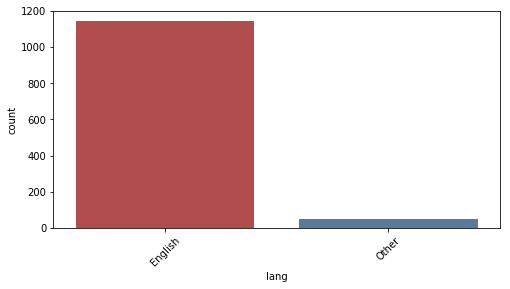

In [21]:
plt.figure(figsize=(8,4))
descending_order = data_copy['lang'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(x="lang", data=data_copy, palette="Set1",saturation = 0.5, order=descending_order)
plt.xticks(rotation=45)
plt.show()

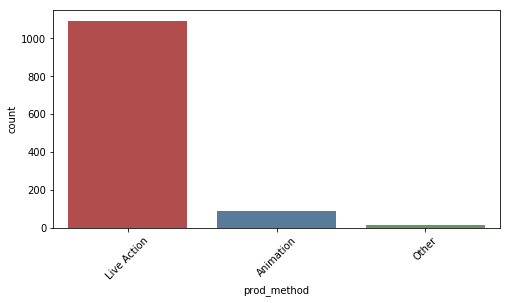

In [22]:
plt.figure(figsize=(8,4))
descending_order = data_copy['prod_method'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(x="prod_method", data=data_copy, palette="Set1",saturation = 0.5, order=descending_order)
plt.xticks(rotation=45)
plt.show()

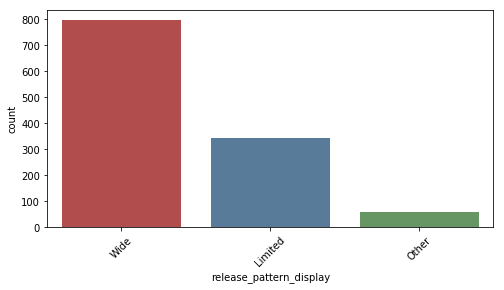

In [23]:
plt.figure(figsize=(8,4))
descending_order = data_copy['release_pattern_display'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(x="release_pattern_display", data=data_copy, palette="Set1",saturation = 0.5, order=descending_order)
plt.xticks(rotation=45)
plt.show()

In [24]:
# Dropping the old columns and keepng the new binned values

data_copy.drop(['language'], axis=1, inplace=True)
data_copy.drop(['production_method'], axis=1, inplace=True)
data_copy.drop(['movie_release_pattern_display_name'], axis=1, inplace=True)

### Insight/ Next steps : Here to make the data statistically profound an ANOVA test could have been run on columns to undertstand the variability within classes. 

### However because of time contraints this was noted as a next step to improve the model prediction

In [25]:
# formatted data snapshot

data_copy.head()

,id,production_year,movie_sequel,creative_type,source,genre,movie_board_rating_display_name,total,lang,prod_method,release_pattern_display
0,7950115,2009,0,Science Fiction,Original Screenplay,Action,PG-13,2784,English,Animation,Wide
1,50950115,2011,1,Fantasy,Based on Fiction Book/Short Story,Adventure,PG-13,1328,English,Animation,Wide
2,119870115,2011,1,Science Fiction,Based on TV,Action,PG-13,1124,English,Animation,Wide
3,119590115,2010,1,Kids Fiction,Original Screenplay,Adventure,G,1064,English,Animation,Wide
4,91700115,2011,1,Fantasy,Based on Theme Park Ride,Adventure,PG-13,1044,English,Live Action,Wide


In [26]:
# Creating a copy of data for further processing

train = data_copy.copy()

## Data Processing

###### Deep diving into the dependent Variable - Target
###### Interest is to detect any skew which would become problematic during the modelling phase


 mu = 104.70 and sigma = 181.85



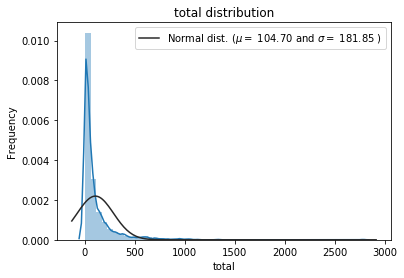

In [27]:
(mu, sigma) = norm.fit(train['total'])

# 1. Plot Sale Price
sns.distplot(train['total'] , fit=norm);
plt.ylabel('Frequency')
plt.title('total distribution')
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

# Get the fitted parameters used by the function
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

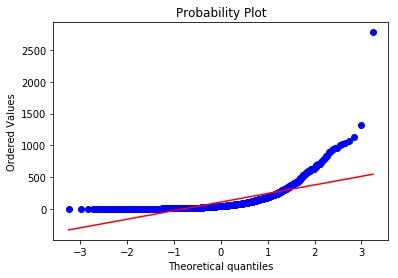

In [28]:
# 2. Plot total as a QQPlot
fig = plt.figure()
res = stats.probplot(train['total'], plot=plt)
plt.show()

###### Insight : We can see here the dependent Variable is right skewed. A log transformation should help bring it back to normality. The code below will complete this

In [29]:
# Applying a log(1+x) transformation to total
train["total"] = np.log1p(train["total"])


 mu = 3.64 and sigma = 1.52



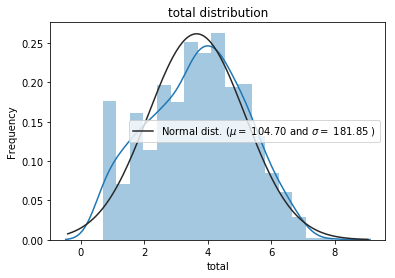

In [30]:
# 1. Plot Sale Price
sns.distplot(train['total'] , fit=norm);
plt.ylabel('Frequency')
plt.title('total distribution')
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['total'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

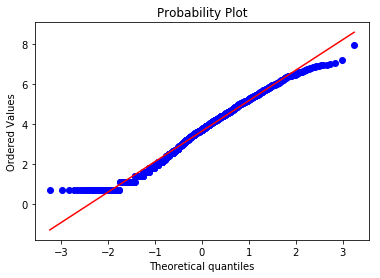

In [31]:
# 2. Plot SalePrice as a QQPlot
fig = plt.figure()
res = stats.probplot(train['total'], plot=plt)
plt.show()

###### Insight :The target variable now looks far more amenable for modelling. Moving on now to some feature engineering

In [32]:
# Saving train & test shapes
ntrain = train.shape[0]

# New all encompassing dataset
all_data = train.copy()

#Creating ID variable
ID =  train.loc[:, train.columns == 'id']

# Dropping the target
all_data.drop(['total'], axis=1, inplace=True)

# Printing all_data shape
print("all_data size is: {}".format(all_data.shape))

all_data size is: (1196, 10)


##### Checking the data set for missing values
##### We'll need to consider these during data processing

In [33]:
# Getting a missing % count
all_data_missing = (all_data.isnull().sum() / len(all_data)) * 100
all_data_missing = all_data_missing.drop(all_data_missing[all_data_missing == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Percentage':all_data_missing})
missing_data.head(5)

,Missing Percentage


###### Our analysis of data reveals that the data frame does not have any missing values.
###### Hence we do not need to do any data imputations in this case

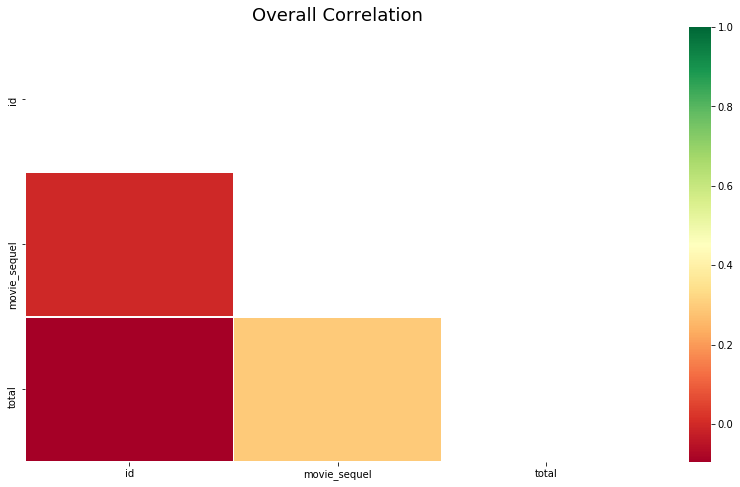

In [34]:
# Initiate correlation matrix
corr = train.corr()
# Set-up mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set-up figure
plt.figure(figsize=(14, 8))
# Title
plt.title('Overall Correlation', fontsize=18)
# Correlation matrix
sns.heatmap(corr, mask=mask, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

###### As the dataset had only one numerical independent variable. We plotted a corelation matrix to get an understanding of the 
###### relationship between dependent varable and independent variable(movie_sequel)

##### Class Imbalance

###### Testinf for any significance class imbalance. Any variable that is represented by a single class by greater than 97% will be removed from the datasets.
###### I also explored the same strategy at the 95% level, but found that model performance decreased. Thus, I will stick at the 97% level.

In [35]:
# Identifying features where a class is over 97% represented
low_var_cat = [col for col in all_data.select_dtypes(exclude=['number']) if 1 - sum(all_data[col] == mode(all_data[col]))/len(all_data) < 0.03]
low_var_cat

[]

### Get dummies
###### Creating dummy variables ready for model building

In [36]:
# Get dummies
all_data = all_data.loc[:, all_data.columns != 'id']

#Production year was dropped from the data set as it did not contribute to model explanation
all_data.drop(['production_year'], axis=1, inplace=True)

all_data = pd.get_dummies(all_data)

all_data = pd.concat([all_data.reset_index(drop=True), ID], axis=1)

all_data.shape

(1196, 54)

# Machine Learning

#### Creating the test set and train set on the training data to undertsand the accuracy of trained model

In [37]:
Xtrain, Xtest, y_train, y_test = train_test_split(all_data, train['total'], test_size = 1/4, random_state = 0)

In [38]:
X_train = Xtrain.copy()
X_test = Xtest.copy()

X_train.drop(['id'], axis=1, inplace=True)
X_test.drop(['id'], axis=1, inplace=True)

### Before modelling defining a function that returns the cross-validation 'rmse' error, following 10-folds. This will ensure that all rmse scores produced have been smoothed out across the entire dataset and are not a result of any irregularities, which otherwise would provide a misleading representation of model performance

In [39]:
# Defining two rmse_cv functions
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

## Generalized linear models
### Focus is on 'regularised' regression models. Regularisation is a form of regression that shrinks (or 'regularises') the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model, so as to avoid the risk of overfitting.

### There are different types of regularised regressions - considerations has been given to 3 of them

## Ridge Regression (L2 Regularisation)

##### Ridge regression shrinks the regression coefficients, so that variables, with minor contribution to the outcome, have their coefficients close to zero.

##### The shrinkage of the coefficients is achieved by penalizing the regression model with a penalty term called L2-norm, which is the sum of the squared coefficients.

##### For regularised regression models, the key tuning parameter is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data. Thus I have defined multiple alpha's, iterate over them and plot the result so we can easily see the optimal alpha level.

In [40]:
# Setting up list of alpha's
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30]
# Iterate over alpha's
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

Text(0,0.5,'Rmse')

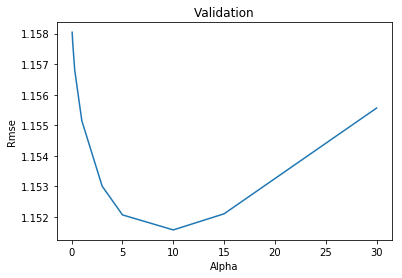

In [41]:
# Plot findings
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

In [42]:
# 5 looks like the optimal alpha level, so let's fit the Ridge model with this value
model_ridge = Ridge(alpha = 10)

## Lasso Regression (L1 regularisation)

##### Lasso stands for Least Absolute Shrinkage and Selection Operator. It shrinks the regression coefficients toward zero by penalizing the regression model with a penalty term called L1-norm, which is the sum of the absolute coefficients.

##### In the case of lasso regression, the penalty has the effect of forcing some of the coefficient estimates, with a minor contribution to the model, to be exactly equal to zero. This means that, lasso can be also seen as an alternative to the subset selection methods for performing variable selection in order to reduce the complexity of the model.

Text(0,0.5,'Rmse')

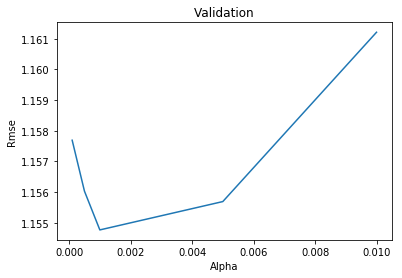

In [43]:
# Setting up list of alpha's
alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001]

# Iterate over alpha's
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() for alpha in alphas]

# Plot findings
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

In [44]:
# Initiating Lasso model
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.001))

## ElasticNet Regression

##### Elastic Net produces a regression model that is penalized with both the L1-norm and L2-norm. The consequence of this is to effectively shrink coefficients (like in ridge regression) and to set some coefficients to zero (as in LASSO)

Text(0,0.5,'Rmse')

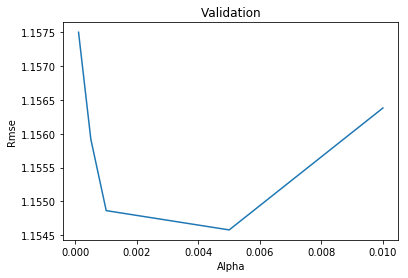

In [45]:
# Setting up list of alpha's
alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001]

# Iterate over alpha's
cv_elastic = [rmse_cv(ElasticNet(alpha = alpha)).mean() for alpha in alphas]

# Plot findings
cv_elastic = pd.Series(cv_elastic, index = alphas)
cv_elastic.plot(title = "Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

In [46]:
# Initiating ElasticNet model
model_elastic = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.005))

## Decision Trees - XG boost

In [47]:
# Initiating XGBRegressor
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2,
                             learning_rate=0.06,
                             max_depth=3,
                             n_estimators=1150)

## Fit all models

In [48]:
# Fitting all models with rmse_cv function
cv_ridge = rmse_cv(model_ridge).mean()
cv_lasso = rmse_cv(model_lasso).mean()
cv_elastic = rmse_cv(model_elastic).mean()
cv_xgb = rmse_cv(model_xgb).mean()

##### Rank model performance

In [49]:
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': ['Ridge',
              'Lasso',
              'ElasticNet',
              'XGBoost Regressor',
              ],
    'Score': [cv_ridge,
              cv_lasso,
              cv_elastic,
              cv_xgb
              ]})

# Build dataframe of values
result_df = results.sort_values(by='Score', ascending=True).reset_index(drop=True)
result_df.head(4)

,Model,Score
0,Ridge,1.151575
1,ElasticNet,1.154580
2,Lasso,1.154769
3,XGBoost Regressor,1.184224


Text(0.5,1,'RMSE')

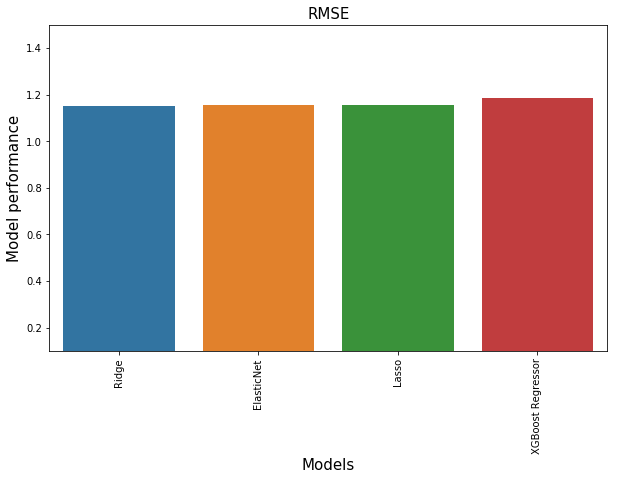

In [50]:
# Plotting model performance
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model performance', fontsize=15)
plt.ylim(0.10, 1.500)
plt.title('RMSE', fontsize=15)

## Stacking algorithms

In [51]:
# Fit and predict all models
model_lasso.fit(X_train, y_train)
lasso_pred = np.expm1(model_lasso.predict(X_test))

model_elastic.fit(X_train, y_train)
elastic_pred = np.expm1(model_elastic.predict(X_test))

model_ridge.fit(X_train, y_train)
ridge_pred = np.expm1(model_ridge.predict(X_test))

model_xgb.fit(X_train, y_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))

## Final predictions

#### Created a stacked model by equally weighting every model 

In [52]:
# Create stacked model
stacked = (lasso_pred + ridge_pred + xgb_pred + elastic_pred) / 4

In [53]:
# Setting up competition submission
sub = pd.DataFrame()
sub['Id'] = Xtest['id']
sub['total'] = stacked

In [54]:
def label_race (row):
    if row['total'] >= 200 :
        return '9'
    if row['total'] >= 150 and row['total'] < 200:
        return '8'
    if row['total'] >= 100 and row['total'] < 150:
        return '7'
    if row['total'] >= 65 and row['total'] < 100:
        return '6'
    if row['total'] >= 40 and row['total'] < 65:
        return '5'
    if row['total'] >= 20 and row['total'] < 40:
        return '4'
    if row['total'] >= 10 and row['total'] < 20:
        return '3'
    if row['total'] >= 1 and row['total'] < 10:
        return '2'
    return '1'

In [55]:
sub['Category'] = sub.apply (lambda row: label_race(row), axis=1)

In [56]:
sub.to_csv('movie_predictions_trainingvalidation.csv',index=False)

# Using Scoring excel to predict 'Category' on test data

In [57]:
# making a copy of the test data for further processing


data_testcopy = df_test.copy()
data_testcopy.drop(['name', 'display_name','production_budget','board_rating_reason'], axis=1, inplace=True)

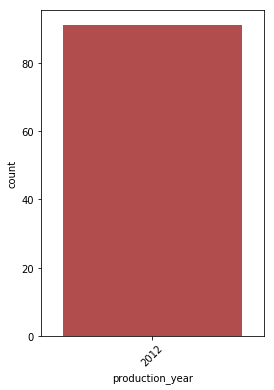

In [58]:
# Plotting a grapg betwwen the count of movies at Production year level

plt.figure(figsize=(4,6))
descending_order = data_testcopy['production_year'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(x="production_year", data=data_testcopy, palette="Set1",saturation = 0.5, order=descending_order)
plt.xticks(rotation=45)
plt.show()

#### Test data had only movies from 2012

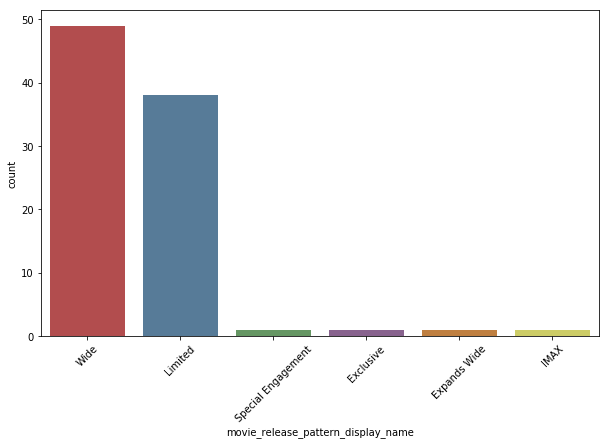

In [59]:
#Plotting data for movie release pattern

plt.figure(figsize=(10,6))
descending_order = data_testcopy['movie_release_pattern_display_name'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(x="movie_release_pattern_display_name", data=data_testcopy, palette="Set1",saturation = 0.5, order=descending_order)
plt.xticks(rotation=45)
plt.show()

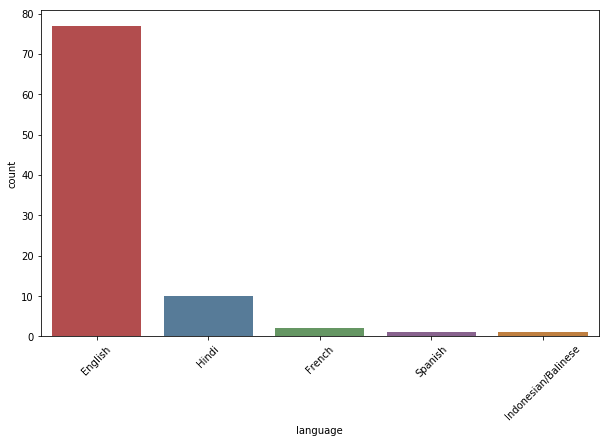

In [60]:
#Plotting data for count of movies and language

plt.figure(figsize=(10,6))
descending_order = data_testcopy['language'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(x="language", data=data_testcopy, palette="Set1",saturation = 0.5, order=descending_order)
plt.xticks(rotation=45)
plt.show()

In [61]:
# Calling user defined functions to carry out binning

data_testcopy['lang'] = data_testcopy.apply (lambda row: label_language(row), axis=1)
data_testcopy['prod_method'] = data_testcopy.apply (lambda row: label_prod_method(row), axis=1)
data_testcopy['release_pattern_display'] = data_testcopy.apply (lambda row: label_release_pattern_display(row), axis=1)

### Plotting values after binning of data was done to achieve generality

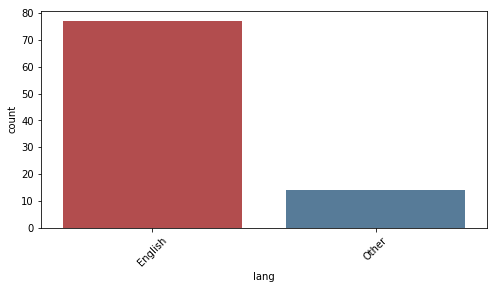

In [62]:
# After binning plot of count of movies vs language
plt.figure(figsize=(8,4))
descending_order = data_testcopy['lang'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(x="lang", data=data_testcopy, palette="Set1",saturation = 0.5, order=descending_order)
plt.xticks(rotation=45)
plt.show()

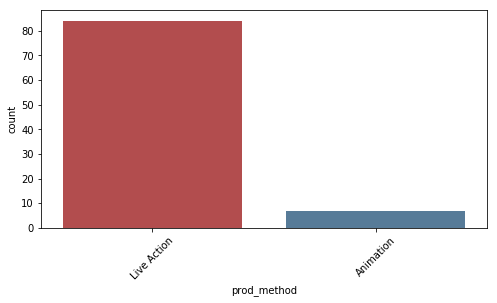

In [63]:
# After binning plot of count of movies vs production Method

plt.figure(figsize=(8,4))
descending_order = data_testcopy['prod_method'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(x="prod_method", data=data_testcopy, palette="Set1",saturation = 0.5, order=descending_order)
plt.xticks(rotation=45)
plt.show()

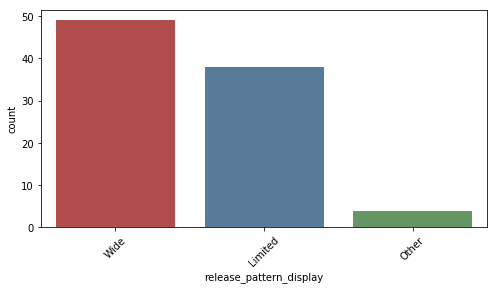

In [64]:
# After binning plot of count of movies vs release_pattern_display

plt.figure(figsize=(8,4))
descending_order = data_testcopy['release_pattern_display'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(x="release_pattern_display", data=data_testcopy, palette="Set1",saturation = 0.5, order=descending_order)
plt.xticks(rotation=45)
plt.show()

In [65]:
# Dropping columns not needed for further analysis

data_testcopy.drop(['language'], axis=1, inplace=True)
data_testcopy.drop(['production_year'], axis=1, inplace=True)
data_testcopy.drop(['production_method'], axis=1, inplace=True)
data_testcopy.drop(['movie_release_pattern_display_name'], axis=1, inplace=True)

In [66]:
score_data = data_testcopy.copy()

In [67]:
score_data.head()

,id,movie_sequel,creative_type,source,genre,movie_board_rating_display_name,lang,prod_method,release_pattern_display
0,7970115,0,Super Hero,Based on Comic/Graphic Novel,Adventure,PG-13,English,Live Action,Wide
1,174540115,1,Super Hero,Based on Comic/Graphic Novel,Action,PG-13,English,Live Action,Wide
2,149080115,1,Contemporary Fiction,Based on Fiction Book/Short Story,Action,PG-13,English,Live Action,Wide
3,136020115,1,Fantasy,Based on Fiction Book/Short Story,Drama,PG-13,English,Live Action,Wide
4,53500115,1,Fantasy,Based on Fiction Book/Short Story,Adventure,PG-13,English,Animation,Wide


### Creating dummy variables as part of feature engineering on test data

In [68]:
# Get dummies
score_data = score_data.loc[:, score_data.columns != 'id']

score_data = pd.get_dummies(score_data)

ID_test =  data_testcopy.loc[:, data_testcopy.columns == 'id']

score_data = pd.concat([score_data.reset_index(drop=True), ID_test], axis=1)

score_data.shape

(91, 41)

### The below code gets the names of columns which are present in train data but not present in test data after feature engineering was done

In [69]:

train_cols = all_data.columns
test_cols = score_data.columns

common_cols = train_cols.intersection(test_cols)
train_not_test = train_cols.difference(test_cols)

In [70]:
print(list(train_not_test))

['creative_type_Multiple Creative Types', 'genre_Black Comedy', 'genre_Multiple Genres', 'genre_Musical', 'genre_Western', 'movie_board_rating_display_name_NC-17', 'prod_method_Other', 'source_Based on Musical or Opera', 'source_Based on Short Film', 'source_Based on Theme Park Ride', 'source_Based on Toy', 'source_Compilation', 'source_Spin-Off']


In [71]:
len(train_not_test)
score_data_dummy = score_data.copy()

In [72]:
columns = list(train_not_test)

In [73]:
df1 = all_data[columns]
df1 = df1[0:len(score_data)]
df1[:] = 0
df1.shape

(91, 13)

In [74]:
score_data = pd.concat([score_data.reset_index(drop=True), df1], axis=1)

In [75]:
score_data.shape

(91, 54)

In [76]:
score_data_model = score_data.copy()

In [77]:
score_data_model.drop(['id'], axis=1, inplace=True)

In [78]:
# predict all models
lasso_pred_test = np.expm1(model_lasso.predict(score_data_model))

In [79]:

elastic_pred_test = np.expm1(model_elastic.predict(score_data_model))


In [80]:

ridge_pred_test = np.expm1(model_ridge.predict(score_data_model))


## stacked model Output

In [81]:

stacked = (lasso_pred_test + ridge_pred_test + elastic_pred_test) / 3

In [82]:
# Setting up competition submission
sub_test = pd.DataFrame()
sub_test['Id'] = score_data['id']
sub_test['total'] = stacked

In [83]:
category= []
for i in range(len(sub_test)):
    if sub_test['total'][i] >= 200 :
        category.append(9)
    elif sub_test['total'][i] >= 150 and sub_test['total'][i] < 200:
        category.append(8)
    elif sub_test['total'][i] >= 100 and sub_test['total'][i] < 150:
        category.append(7)
    elif sub_test['total'][i] >= 65 and sub_test['total'][i] < 100:
        category.append(6)
    elif sub_test['total'][i] >= 40 and sub_test['total'][i] < 65:
        category.append(5)
    elif sub_test['total'][i] >= 20 and sub_test['total'][i] < 40:
        category.append(4)
    elif sub_test['total'][i] >= 10 and sub_test['total'][i] < 20:
        category.append(3)
    elif sub_test['total'][i] >= 1 and sub_test['total'][i] < 10:
        category.append(2)
    else:
        category.append(1)

In [84]:
dfObj = pd.DataFrame(category)
sub_test = pd.concat([sub_test.reset_index(drop=True), dfObj], axis=1)
sub_test = sub_test.rename(columns={0: 'Category'})
sub_test.head()

,Id,total,Category
0,7970115,38.734280,4
1,174540115,66.227041,6
2,149080115,42.057585,5
3,136020115,43.721314,5
4,53500115,124.828666,7


In [86]:
# Make a csv for submission

sub_test.to_csv('movie_predictions_testvalidation.csv',index=False)